# Part III: Mesh Processing

In [1]:
import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import open3d
import trimesh
print(trimesh.__version__)

WARNING - 2022-10-23 21:52:27,920 - graph - graph-tool unavailable, some operations will be much slower
WARNING - 2022-10-23 21:52:27,993 - assimp - pyassimp unavailable, using only native loaders
WARNING - 2022-10-23 21:52:28,020 - creation - shapely.geometry.Polygon not installed, some functions will not work!


2.3.13


In [2]:
vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

# Make sure you call this function to draw the points for proper viewing direction
def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1, 0))
    view_ctl.set_front((0, 2, 1))
    view_ctl.set_lookat((0, 0, 0))
    view_ctl.set_zoom(1)
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img))
    for g in geoms:
        vis.remove_geometry(g)

def create_arrow_from_vector(origin, vector):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(cylinder_radius=0.025, cone_radius=0.05, cylinder_height=0.25, 
                                                      cone_height=0.2)
    arrow.paint_uniform_color([1,0,1])
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

In [3]:
def compute_face_normals(mesh):
    num_faces = mesh.faces.shape[0]
    num_vertices = mesh.vertices.shape[0]

    face_normals = []
    
    for itr in tqdm(range(num_faces)):
        vertices_idx = mesh.faces[itr]   # (3,)
        vertices = mesh.vertices[vertices_idx]   # 3x3

        # compute edge vectors for each face
        edges = np.zeros((3,3))
        edges[0] = vertices[2] - vertices[1]
        edges[1] = vertices[0] - vertices[2]
        edges[2] = vertices[1] - vertices[0]

        # compute face orthonormal basis vectors using Gram-Schmidt orthogonalization
        Dfp = np.zeros((3,2))
        Dfp[:,0] = edges[0]
#         assert(np.dot(edges[0], edges[0]) - np.linalg.norm(edges[0])**2 <= 1e-10)
        proj_component = (np.dot(edges[1], edges[0]) / np.dot(edges[0], edges[0])) * edges[0]
        Dfp[:,1] = edges[1] - proj_component
        Dfp = Dfp / np.linalg.norm(Dfp, axis=0)
#         assert(np.dot(Dfp[:,0], Dfp[:,1]) <= 1e-10)

        # compute face normal
        face_normal = np.cross(Dfp[:,0], Dfp[:,1])
        face_normals.append(face_normal)
    
    face_normals = np.array(face_normals)
    return face_normals

## Function to compute shape operator

In [4]:
def compute_shape_operator(mesh):
    num_faces = mesh.faces.shape[0]
    num_vertices = mesh.vertices.shape[0]

    start_time = time.time()

    # compute face normals
#     face_normals = compute_face_normals(mesh)
    face_normals = mesh.face_normals
    
    # compute vertex normals
    vertex_normals = trimesh.geometry.mean_vertex_normals(num_vertices, mesh.faces, face_normals)
#     pcd.estimate_normals(open3d.geometry.KDTreeSearchParamKNN(knn=50))
    
    principal_curv = np.zeros((num_faces, 2))

    for itr in tqdm(range(num_faces)):
        vertices_idx = mesh.faces[itr]   # (3,)
        vertices = mesh.vertices[vertices_idx]   # 3x3

        # compute edge vectors for each face
        edges = np.zeros((3,3))
        edges[0] = vertices[2] - vertices[1]
        edges[1] = vertices[0] - vertices[2]
        edges[2] = vertices[1] - vertices[0]

        # compute face orthonormal basis vectors using Gram-Schmidt
        Dfp = np.zeros((3,2))
        Dfp[:,0] = edges[0]
        proj_component = (np.dot(edges[1], edges[0]) / np.dot(edges[0], edges[0])) * edges[0]
        Dfp[:,1] = edges[1] - proj_component
        Dfp = Dfp / np.linalg.norm(Dfp, axis=0)
#         assert(np.dot(Dfp[:,0], Dfp[:,1]) <= 1e-10)

        lhs1 = np.matmul(Dfp.T, edges[0])
        rhs1 = np.matmul(Dfp.T, vertex_normals[vertices_idx[2]] - vertex_normals[vertices_idx[1]])

        lhs2 = np.matmul(Dfp.T, edges[1])
        rhs2 = np.matmul(Dfp.T, vertex_normals[vertices_idx[0]] - vertex_normals[vertices_idx[2]])

        lhs3 = np.matmul(Dfp.T, edges[2])
        rhs3 = np.matmul(Dfp.T, vertex_normals[vertices_idx[1]] - vertex_normals[vertices_idx[0]])

        A = np.array([lhs1, lhs2, lhs3]).T
        B = np.array([rhs1, rhs2, rhs3]).T

        S = np.matmul(np.matmul(B, A.T), np.linalg.inv(np.matmul(A, A.T)))
        
        principal_curv[itr], _ = np.linalg.eig(S)
    
    print("Time taken:", round(time.time() - start_time, 3), 's')
    
    return principal_curv

## Load Sievert Object

Vertices: (10201, 3) Faces: (20000, 3) 0 10200


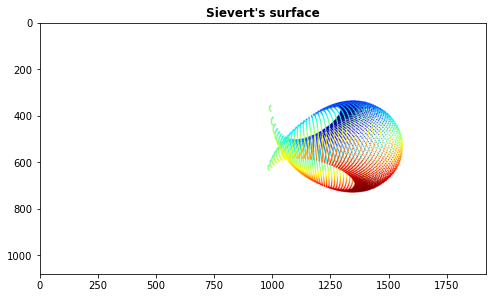

In [5]:
mesh_sievert = trimesh.load('../data/sievert.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(mesh_sievert.vertices)
# vertex_normals = pcd.estimate_normals(open3d.geometry.KDTreeSearchParamKNN(knn=50))
# print("Vertex normals:", vertex_normals)
draw_geometries([pcd])
plt.title("Sievert's surface", fontweight ="bold")

print(mesh_sievert)
print("Vertices:", mesh_sievert.vertices.shape, "Faces:", mesh_sievert.faces.shape, 
      mesh_sievert.faces.min(), mesh_sievert.faces.max())

## Compute principal, gaussian and mean curvatures for Sievert surface

In [6]:
principal_curv_sievert = compute_shape_operator(mesh_sievert)
gauss_curv_sievert = np.multiply(principal_curv_sievert[:,0], principal_curv_sievert[:,1])
mean_curv_sievert = 0.5 * np.add(principal_curv_sievert[:,0], principal_curv_sievert[:,1])

  0%|          | 0/20000 [00:00<?, ?it/s]

Time taken: 16.816 s


## Load Icosphere Object

(10242, 3) (20480, 3) 0 10241


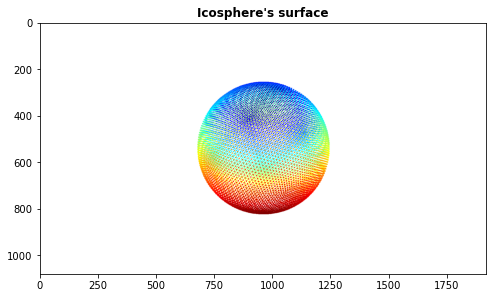

In [8]:
mesh_icosphere = trimesh.load('../data/icosphere.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(mesh_icosphere.vertices)
draw_geometries([pcd])
plt.title("Icosphere's surface", fontweight ="bold")

print(mesh_icosphere)
print(mesh_icosphere.vertices.shape, mesh_icosphere.faces.shape, mesh_icosphere.faces.min(), mesh_icosphere.faces.max())

## Compute principal, gaussian and mean curvatures for Icosphere object

In [9]:
principal_curv_icosphere = compute_shape_operator(mesh_icosphere)
gauss_curv_icosphere = np.multiply(principal_curv_icosphere[:,0], principal_curv_icosphere[:,1])
mean_curv_icosphere = 0.5 * np.add(principal_curv_icosphere[:,0], principal_curv_icosphere[:,1])

  0%|          | 0/20480 [00:00<?, ?it/s]

<ipython-input-4-7ce98e4b001a>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  principal_curv[itr], _ = np.linalg.eig(S)


Time taken: 15.44 s


## Plot gaussian curvature for Sievert & Icosphere object

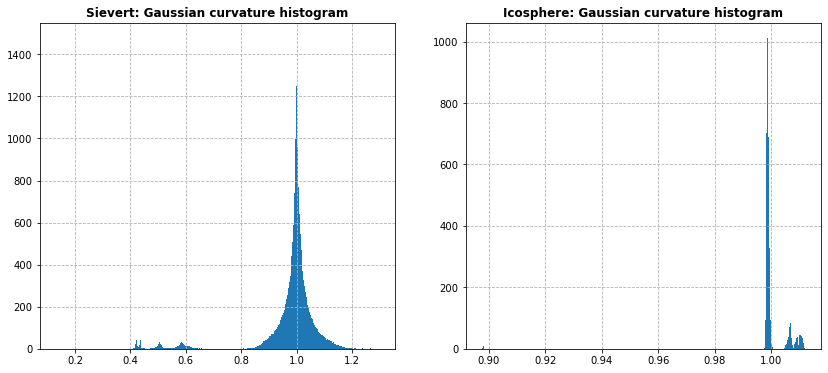

In [10]:
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(gauss_curv_sievert, bins='auto')
plt.title("Sievert: Gaussian curvature histogram", fontweight ="bold")
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.hist(gauss_curv_icosphere, bins='auto')
plt.title("Icosphere: Gaussian curvature histogram", fontweight ="bold")
plt.grid(linestyle='--')

## Plot mean curvature for Sievert and Icosphere object

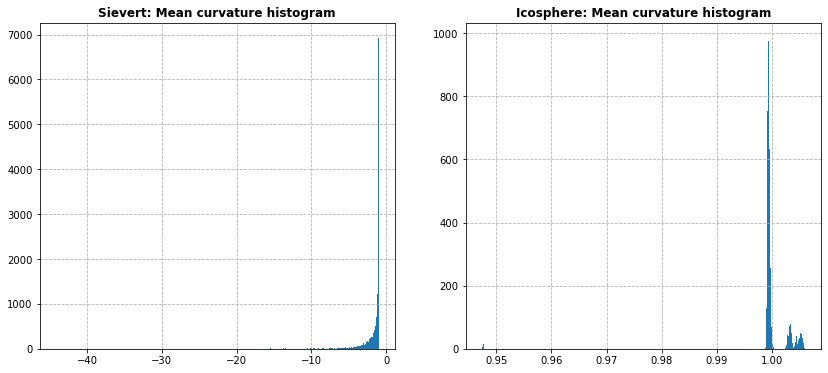

In [11]:
fig = plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
_ = plt.hist(mean_curv_sievert, bins='auto')
plt.title("Sievert: Mean curvature histogram", fontweight ="bold")
plt.grid(linestyle='--')

plt.subplot(1,2,2)
_ = plt.hist(mean_curv_icosphere, bins='auto')
plt.title("Icosphere: Mean curvature histogram", fontweight ="bold")
plt.grid(linestyle='--')

### - Comparing the gaussian curvatures for Sievert and Icosphere object, we can say that the sievert surface is locally isometric to some region on the icosphere object. 

### - The right semi-spherical part of sievert surface is locally isometric to the right part of icosphere